# Modeling part. Stroke prediction.

This is the second notebook for our stroke prediction project. In this notebook, our primary objective is to select the best-performing model. We will explore the inclusion of new features and compare various machine learning models to identify the most effective one for our prediction task.

We will evaluate the performance of different models using metrics such as accuracy, recall, precision, F1 score, and the area under the ROC curve (AUC). This process will include hyperparameter tuning and model ensembling. Our focus is on selecting the model with the highest ROC AUC, as it balances high accuracy with good recall and precision. Additionally, we will try the SMOTE technique to address class imbalance.

## Results:
**XGBoost** was selected as the final model for predicting stroke risk. The model was trained using the original features provided in the dataset, with age identified as the most significant predictor. Other important features include hypertension, heart disease, work type, and smoking status.

**AdaBoost** and **Decision Tree** models also performed similarly to the XGBoost model. However, XGBoost was chosen for the following reasons:

* Highest ROC AUC: Although the difference was small, XGBoost achieved the highest ROC AUC score.
* Feature Importance: While age was the most important feature across all models, XGBoost took into account a broader range of features when predicting stroke risk. This suggests that XGBoost may be better at identifying complex patterns in the data. We believe that by training this model on a larger dataset in the future, we can achieve even better results.

The Decision Tree model, with a depth of 2, primarily used the age feature for splitting. This further underscores the simplicity and limited size of our dataset.

## Recommendations for Addressing the Problem:
* Prioritize Elderly Care: Since older adults are at the greatest risk for stroke, it is essential to ensure they have access to proper healthcare services and medications tailored to their needs.
* Focus on Hypertension and Heart Disease: Individuals with hypertension and heart disease require targeted care and monitoring. Additionally, those who are self-employed or work in government roles may benefit from focused interventions. Promoting healthier lifestyles, encouraging regular physical activity, and supporting mental health within these groups could lead to significant improvements in their overall health and reduce stroke risk.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder, 
                                   OrdinalEncoder, 
                                   FunctionTransformer,
                                   MinMaxScaler)
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as pipeline
from sklearn.base import clone
import shap
import sys
import os
sys.path.append(os.path.abspath('..'))
from utils import helper_functions

Import train and test sets. In addition we copy train set data to encoded_train. We will use encoded_train dataset for creating new features and selecting the best ones.

In [4]:
train_set = pd.read_csv("train_set.csv", index_col=0)
test_set = pd.read_csv("test_set.csv", index_col=0)
encoded_train = train_set.drop(columns="id").copy()

## Feature Engineering and Selection

We decided to engineer some new features which are combination of our existing features. Before creating them, let's:
* encode categorical variables
* fill in missing values for bmi and smoking_status columns. For bmi we will use mean imputation, while for smoking_status, KNN imputation will be used. As we saw there were more than 1000 missing values for this column. Therefore, by using KNN imputation, we hope to uncover some pattern which improves our model. It has to be noted that for imputation, we have to standardize our numerical columns. We will use min-max standardization for age. For bmi and avg_glucose_level we will apply logarithmic transformation and then standardization.

In [5]:
# ordinal encoder for binary columns
ordinal_transformer = OrdinalEncoder()

encoded_train[["gender", "ever_married", "Residence_type"]] = (
    ordinal_transformer.fit_transform(encoded_train[["gender", 
                                                     "ever_married",
                                                     "Residence_type"]]))

In [6]:
# ordinal encoder for smoking_status column
smoking_transformer = OrdinalEncoder(categories=[["never smoked", 
                                                 "formerly smoked", 
                                                 "smokes"]],
                                    handle_unknown="use_encoded_value",
                                    unknown_value=np.nan)

encoded_train["smoking_status"] = smoking_transformer.fit_transform(
    encoded_train[["smoking_status"]])

In [7]:
# one-hot encoding for work_type column
encoded_train = pd.concat([encoded_train, 
                           pd.get_dummies(encoded_train["work_type"])], axis=1)
encoded_train = encoded_train.drop(columns="work_type")

In [8]:
# imputation of bmi column
encoded_train["bmi"] = encoded_train["bmi"].fillna(encoded_train["bmi"].mean())

In [9]:
# standardizing numeric columns
numeric_columns = ["age", "avg_glucose_level", "bmi"]
min_max = ["age"]
log_standardize_col = ["avg_glucose_level", "bmi"]

log_transformer = FunctionTransformer(np.log, validate=True, 
                                      feature_names_out="one-to-one")

# apply transformation to numerical columns before imputation
age_transformer = MinMaxScaler()
log_standardize = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('log', log_transformer),
    ('standardize', StandardScaler())
])

passthrough_columns = encoded_train.drop(
    columns=numeric_columns+["stroke"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('min_max', age_transformer, ["age"]),
        ('log_std', log_standardize, log_standardize_col),
        ('pass', 'passthrough', passthrough_columns)
    ])

In [10]:
# do KNN imputation
smoke_impute_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("knn_impute", KNNImputer(n_neighbors=3))
])
encoded_train["smoking_status"] = smoke_impute_pipe.fit_transform(encoded_train)[:, 8]

Below are the 4 features we will create.

In [11]:
encoded_train["smoking_status*age"] = (encoded_train["smoking_status"] 
                                       * encoded_train["age"])

encoded_train["avg_glucose*age"] = (encoded_train["avg_glucose_level"] 
                                    * encoded_train["age"])

encoded_train["avg_glucose*bmi"] = (encoded_train["avg_glucose_level"] 
                                    * encoded_train["bmi"])

encoded_train["heart_disease*hypertension"] = (encoded_train["heart_disease"] * 
                                               encoded_train["hypertension"])

To check whether these features may improve our model, we will do the following:
* look at mutual information scores
* look at the correlation matrix

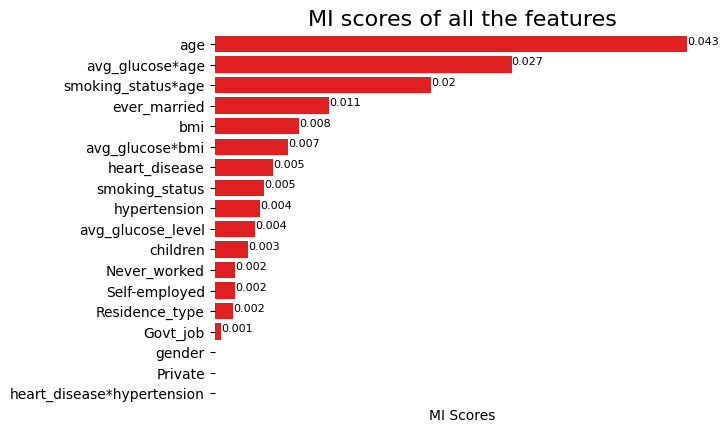

In [12]:
mi_scores = helper_functions.make_mi_scores(encoded_train.drop(columns="stroke"), 
                                            encoded_train.loc[:, "stroke"],
                                            random_state=2)
ax = sns.barplot(mi_scores, orient="h", color="red")
helper_functions.customize_bar(position="h", axes=ax, round_to=3, values_font=8)
plt.title("MI scores of all the features", fontsize=16);

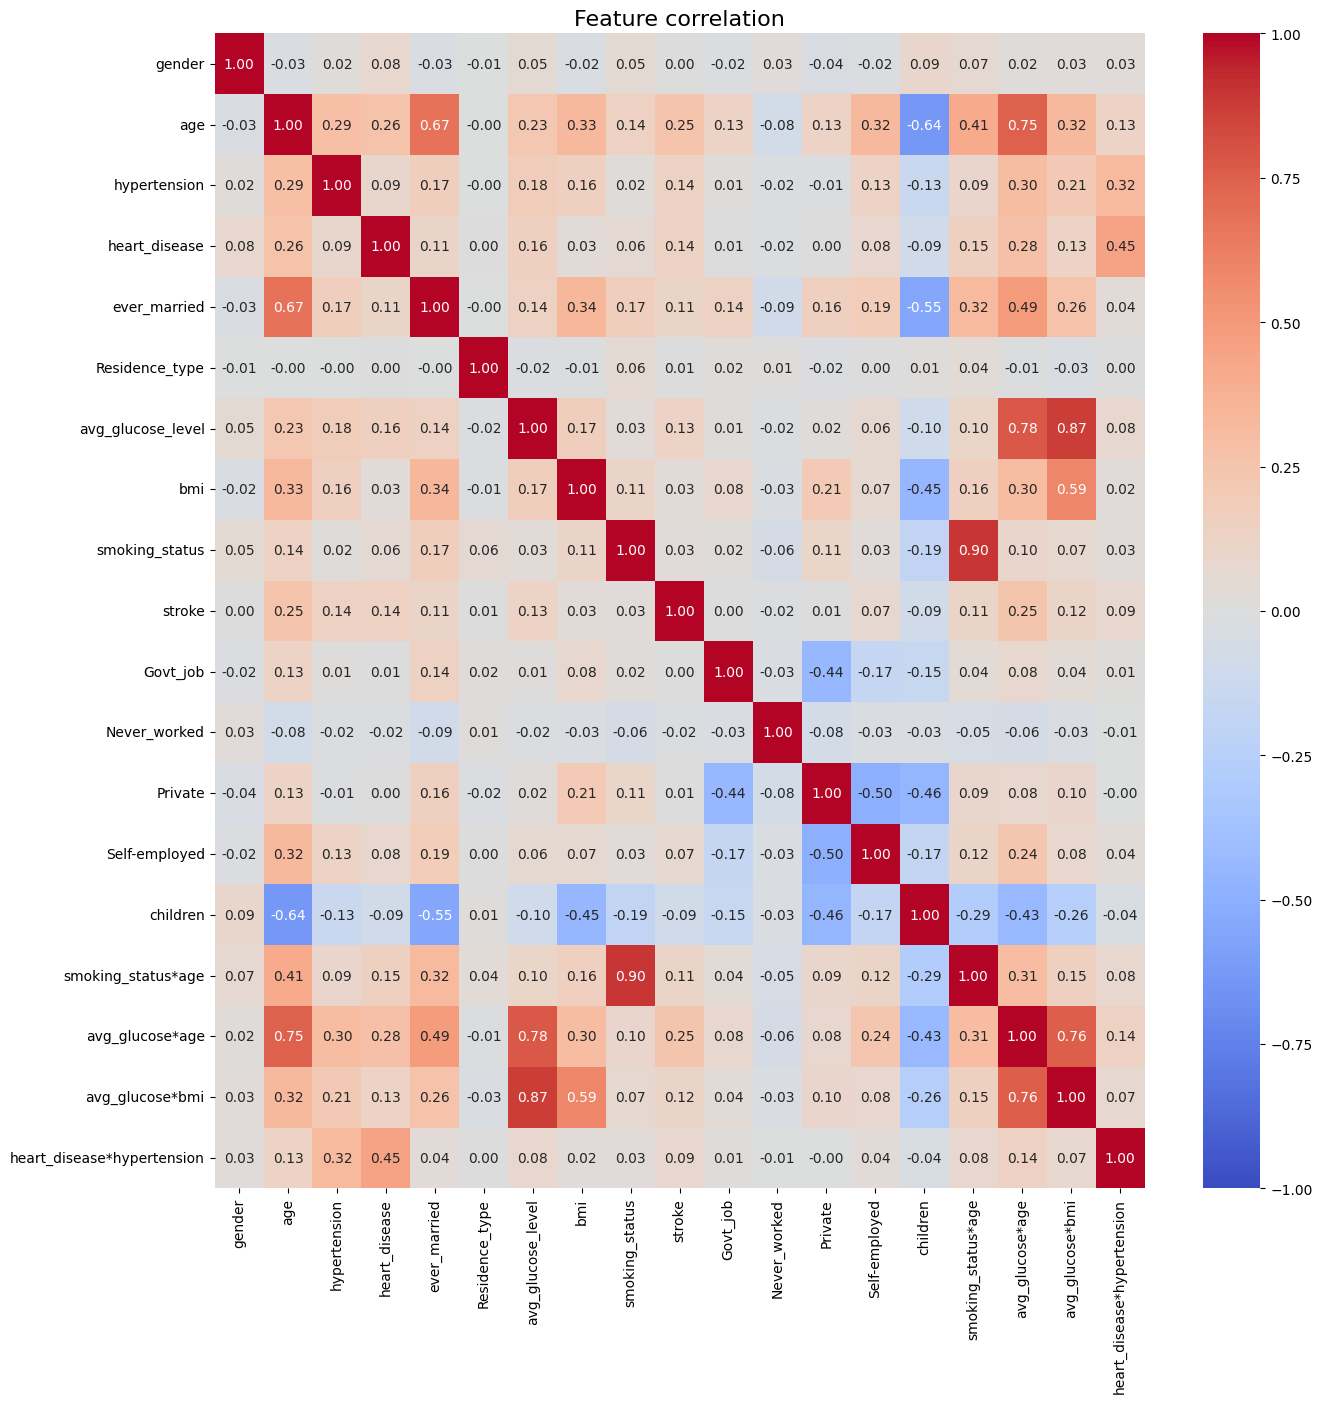

In [13]:
plt.figure(figsize=(15, 15))
plt.title("Feature correlation", fontsize=16)
sns.heatmap(encoded_train.corr(), annot=True, fmt=".2f",
           cmap="coolwarm", vmin=-1, vmax=1);

New features don't seem to provide any new information. heart_disease * hypertension has very low mutual information score. avg_glucose * bmi is strongly correlated with avg_glucose. Therefore, it is better to keep the simple original column. smoking_status * age is also strongly correlated with original smoking_status column, so we drop it. The same can be said about avg_glucose*age columns. Therefore, we will stick to our original features.

In [14]:
encoded_train.drop(columns=["smoking_status*age", "avg_glucose*bmi",
                            "heart_disease*hypertension", "avg_glucose*age"], 
                   inplace=True)

## Modeling

We will start with the following algorithms:
* **Logistic Regression**
* **Decision Tree**
* **Random Forest**
* **Support Vector Machine(Linear, rbf kernel)**

To select the best model, we will use the Area Under the ROC Curve (AUC-ROC) as our primary evaluation metric. Given that our dataset is highly imbalanced, AUC-ROC is an optimal choice because it effectively assesses the model's ability to distinguish between classes across various classification thresholds. This metric helps balance the trade-off between recall and precision, ensuring that the model performs well overall. Additionally, AUC-ROC allows us to adjust the decision threshold to better align with specific needs or priorities.

Specify cross-validation strategy and scores that we want to see.

In [15]:
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
cv = StratifiedKFold(n_splits=5)

Create X and y sets

In [16]:
X = train_set.drop(columns=["id", "stroke"])
y = train_set["stroke"]

Before training models, let's create full pipeline which transforms our dataset

In [17]:
# ordinal encoding of binary columns
ordinal_transformer = OrdinalEncoder()

# smoking encoding before KNN-imputation
smoking_transformer = OrdinalEncoder(categories=[["never smoked", 
                                                 "formerly smoked", 
                                                 "smokes"]],
                                    handle_unknown="use_encoded_value",
                                    unknown_value=np.nan)

# one-hot encoding of work-type column
work_type_transformer = OneHotEncoder()

binary_col = ["gender", "ever_married", "Residence_type"]

cat_encode = ColumnTransformer(
    transformers=[
        ('binary_encode', ordinal_transformer, binary_col),
        ('smoking_encode', smoking_transformer, ["smoking_status"]),
        ('work_type_onehot', work_type_transformer, ["work_type"]),
    ])

In [18]:
# preprocessing of numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('min_max', age_transformer, ["age"]),
        ('log_std', log_standardize, ["bmi", "avg_glucose_level"]),
    ])

# encoding of all the columns
encode_transform = ColumnTransformer(
    transformers=[
        ('numerical', preprocessor, numeric_columns),
        ('categorical', cat_encode, binary_col+["smoking_status", "work_type"])
    ], remainder="passthrough", force_int_remainder_cols=False
)

# pipeline which encodes the columns and applies KNN-imputation
preprocessing = Pipeline([
    ("preprocess", encode_transform),
    ("knn_impute", KNNImputer(n_neighbors=3))
])

Plot the results on training data for each algorithm. It is important to point out that we will use class_weight="balanced" parameter in order to address imbalance here. 

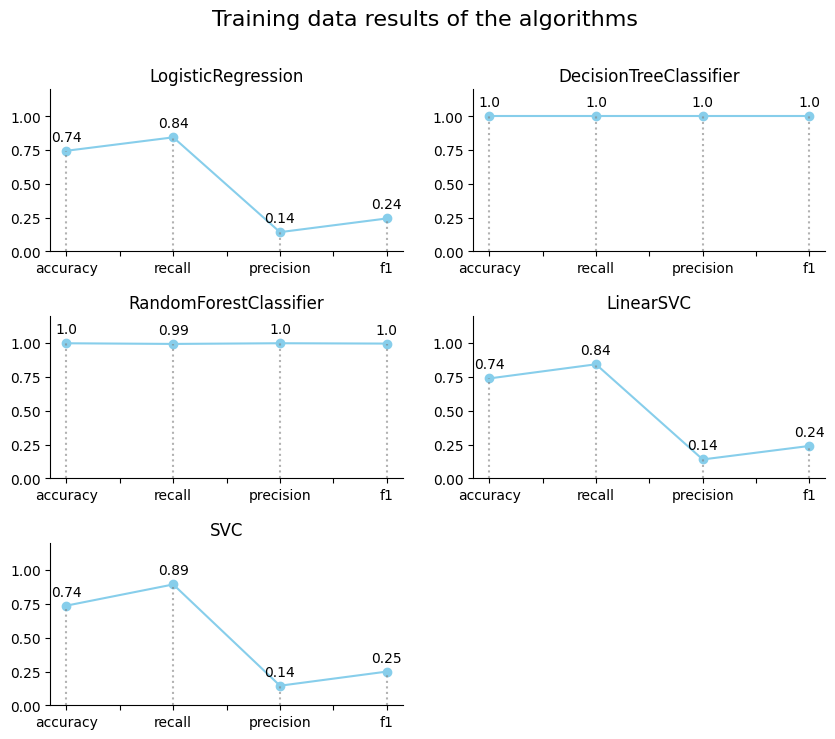

In [19]:
algorithms = [LogisticRegression(C=1, class_weight="balanced"),
             DecisionTreeClassifier(random_state=0, class_weight="balanced"),
             RandomForestClassifier(random_state=0, class_weight="balanced"),
             svm.LinearSVC(random_state=0, class_weight="balanced"),
             svm.SVC(random_state=0, kernel="rbf", C=1, gamma=0.1, 
                     class_weight="balanced")]
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Training data results of the algorithms", fontsize=16)

# train each algorithm and plot the scores
for i, algorithm in enumerate(algorithms):
    ax = fig.add_subplot(3, 2, i+1)
    preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])
    
    pipe = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("algorithm", algorithm)])
    
    original_res = pd.Series(helper_functions.get_scores(pipe, X, y))
    original_res.plot(ax=ax, marker='o', color='skyblue')
    ax.set_ylim(0, 1.2)
    title = str(algorithm)[:str(algorithm).find("(")]
    ax.set_title(title)
    sns.despine()
    
    # add text annotation and vertical lines
    for x_coor in original_res.index:
        y_corr = original_res.loc[x_coor]
        ax.text(x_coor, y_corr+0.05, round(y_corr, 2), ha='center', 
                      va='bottom', fontsize=10)
        ax.vlines(x_coor, ymin=0, ymax=y_corr, colors='gray', 
                   linestyles='dotted', alpha=0.6)

Support Vector Machine algorithms and Logistic Regression show pretty similar results. Tree algorithms show perfect results indicating possible overfitting.

As it was mentioned before, our dataset is highly imbalanced. Because of that, it is hard for our model to identify positive class. To address this problem further, let's also try SMOTE oversampling technique. We will compare both approaches:
* SMOTE
* No oversampling, only class_weights="balanced" parameter

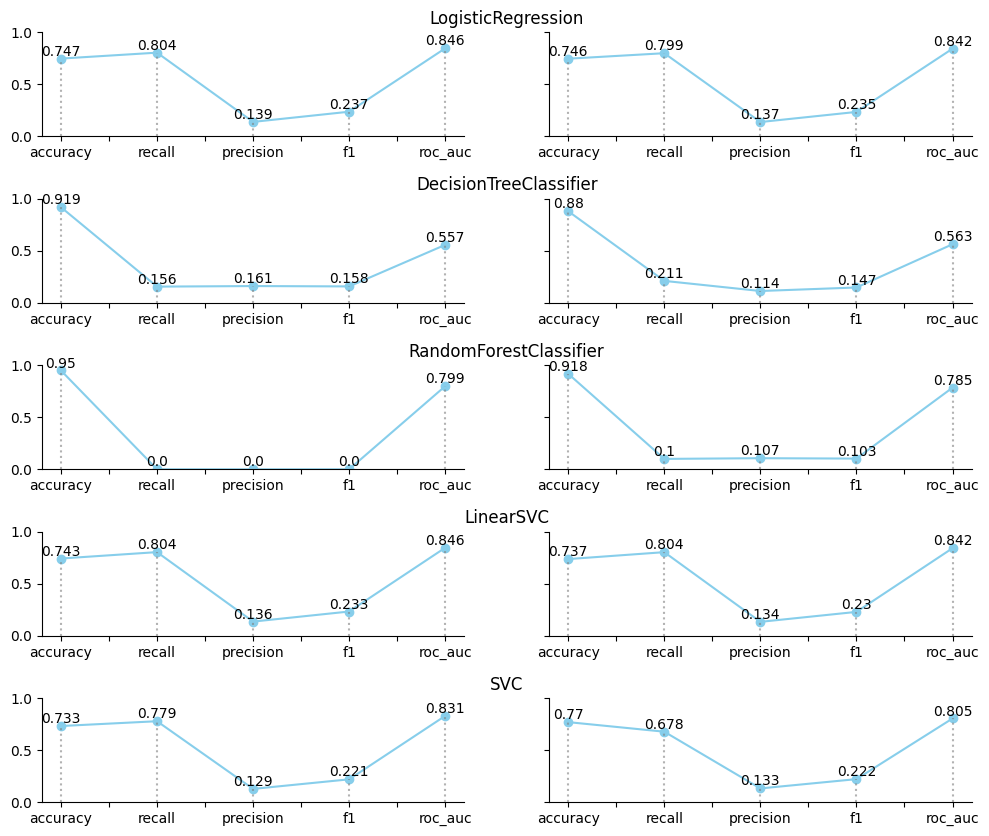

In [20]:
algorithms = [LogisticRegression(C=1, class_weight="balanced"),
              DecisionTreeClassifier(random_state=1, class_weight="balanced"),
              RandomForestClassifier(random_state=1, class_weight="balanced"),
              svm.LinearSVC(random_state=0, class_weight="balanced"),
              svm.SVC(random_state=0, kernel="rbf", C=1, gamma=0.1, 
                      class_weight="balanced")]
fig, ax = plt.subplots(5, 2, figsize=(12, 10), sharey=True)
plt.subplots_adjust(hspace=0.6)

# list of pipelines for each algorithm
pipelines = []

# use cross-validation for each algorithm for each approach
for i, algorithm in enumerate(algorithms[:]):
    
    # pipeline without oversampling
    preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])
    
    pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("algorithm", algorithm)])
    pipelines.append(pipe_original)
    
    
    # column Transformer is created, becuase SMOTE pipeline
    # doesn't accept scikit-learn pipelines
    preprocessing_transformer = ColumnTransformer(transformers=[
        ("all", preprocessing, X.columns)
    ])
    
    # pipeline using SMOTE
    pipe_smote = pipeline(steps=[
        ("preprocessing", preprocessing_transformer),
        ("smote", SMOTE()), 
        ("algorithm", algorithm)])
    
    original_avg = pd.DataFrame(helper_functions.cross_val_scores(pipe_original,
                                                                  X, 
                                                                  y, 
                                                                  scoring=scoring,
                                                                  cv=cv)).mean()
    smote_avg = pd.DataFrame(helper_functions.cross_val_scores(pipe_smote, X, 
                                                               y, 
                                                               scoring=scoring, 
                                                               cv=cv)).mean()
    
    title = str(algorithm)[:str(algorithm).find("(")]
    
    ax[i, 0].set_title(title, x=1.1)
    original_avg.plot(ax=ax[i, 0], marker='o', color='skyblue')
    smote_avg.plot(ax=ax[i, 1], marker='o', color='skyblue')
    sns.despine()
    
    ax[i, 0].set_ylim(0, 1)
    # add annotations and vertical lines
    for x_coor in original_avg.index:
        y_corr0 = original_avg.loc[x_coor]
        y_corr1 = smote_avg.loc[x_coor]
        ax[i, 0].text(x_coor, y_corr0, round(y_corr0, 3), ha='center', 
                      va='bottom', fontsize=10)
        ax[i, 0].vlines(x_coor, ymin=0, ymax=y_corr0, colors='gray', 
                        linestyles='dotted', alpha=0.6)
        
        ax[i, 1].text(x_coor, y_corr1, round(y_corr1, 3), ha='center', 
                      va='bottom', fontsize=10)
        ax[i, 1].vlines(x_coor, ymin=0, ymax=y_corr1, colors='gray', 
                        linestyles='dotted', alpha=0.6)

We see here that Random Forest and Decision Tree algorithms are highly overfitting. They fail to identify positive classes. Other algorithms seem to not overfit. The results using oversampling are almsost the same as without it. Therefore, to make things simple, we will not use it. We will stick to class_weights="balanced" parameter.

Let's also plot confusion matrices for our algorithms:

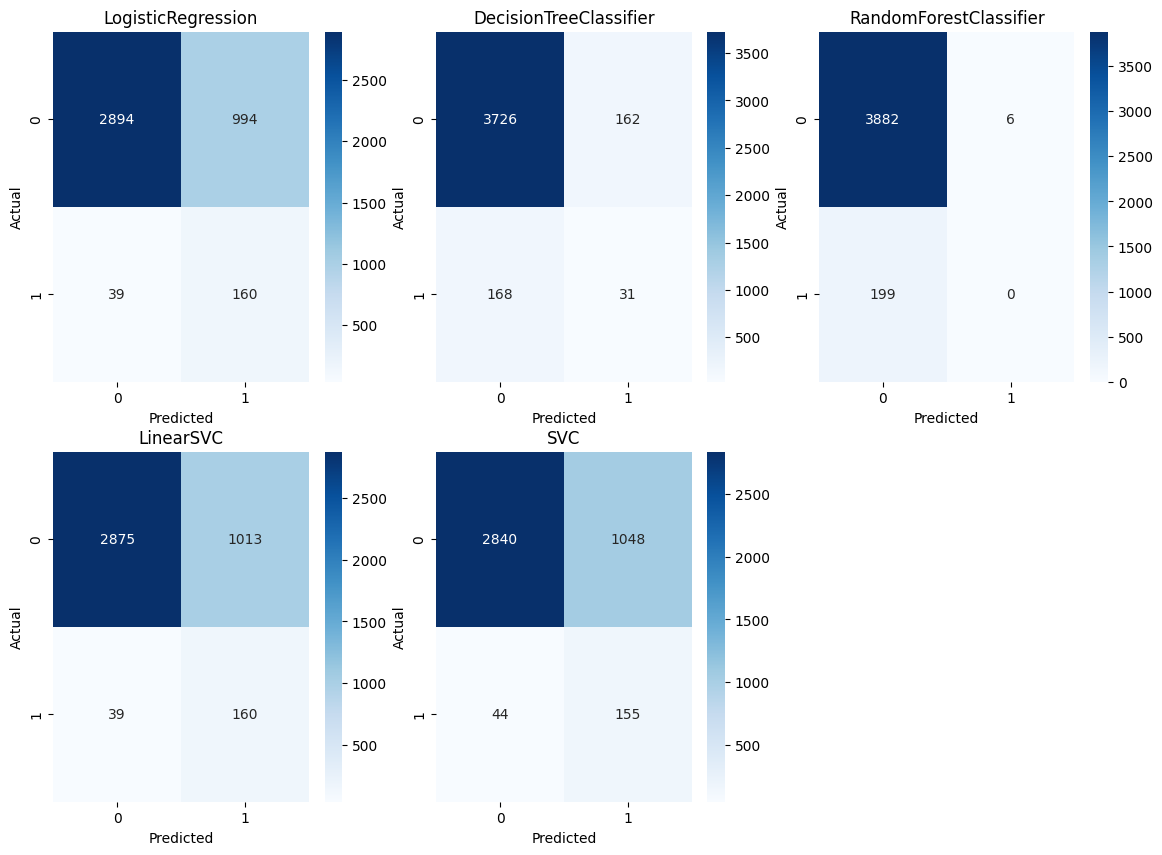

In [21]:
helper_functions.plot_confusion_matrices(pipelines, X, y, figsize=(14, 10))

As the tree algorithms are highly dependent on hyperparameters, to understand their real potential, we will use hyperparameter tuning. Logistic Regression has shown the best results as for now. It has the highest precision and recall. Support Vector Machine algorithms are pretty similar.

**Hyperparameter tuning**

We will try to find best parameters for all models.

**LogisticRegression**

In [22]:
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]
}

preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])

pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("log_reg", LogisticRegression(class_weight="balanced"))])

best_log_reg, best_log_reg_res = helper_functions.find_best_parameters(
    pipe_original, param_grid, X, y, scoring, cv, "roc_auc")
best_log_reg_res

,mean,std
accuracy,0.747243,0.013048
recall,0.804103,0.076271
precision,0.138756,0.012679
f1,0.236612,0.021483
roc_auc,0.845911,0.033067


**Decision Tree**

In [23]:
param_grid = {
    'tree__max_depth': list(range(1, 6)),
    'tree__max_features': ['sqrt', 'log2', None],
    'tree__criterion': ["gini", "entropy"],
    'tree__min_samples_split': [2, 5, 10, 50, 100]
}

preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])

pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("tree", DecisionTreeClassifier(class_weight="balanced"))])

best_tree, best_tree_res = helper_functions.find_best_parameters(
    pipe_original, param_grid, X, y, scoring, cv, "roc_auc")
best_tree_res

,mean,std
accuracy,0.697579,0.016073
recall,0.864744,0.071461
precision,0.124615,0.007809
f1,0.21775,0.013538
roc_auc,0.832804,0.028284


**Random Forest**

In [26]:
param_grid = {
    'forest__n_estimators': [100, 200],
    'forest__max_features': ['sqrt', 'log2', None],
    'forest__max_depth': [1, 2, 3, 4, 5]
}

preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])

pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("forest", RandomForestClassifier(class_weight="balanced"))])

best_forest, best_forest_res = helper_functions.find_best_parameters(
    pipe_original, param_grid, X, y, scoring, cv, "roc_auc")
best_forest_res

,mean,std
accuracy,0.701984,0.01448
recall,0.859615,0.065959
precision,0.125727,0.008265
f1,0.219312,0.014291
roc_auc,0.845583,0.031007


**Linear Support Vector Machine**

In [27]:
param_grid = {
    'linear_svc__C': [0.01, 0.1, 1, 10, 100],
}

preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])

pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("linear_svc", svm.LinearSVC(random_state=0, class_weight="balanced"))])

best_linear_svc, best_linear_svc_res = helper_functions.find_best_parameters(
    pipe_original, param_grid, X, y, scoring, cv, "roc_auc")
best_linear_svc_res

,mean,std
accuracy,0.739169,0.010805
recall,0.804103,0.076271
precision,0.134824,0.012186
f1,0.230894,0.02087
roc_auc,0.846648,0.031659


**Support Vector Machine(rbf kernel)**

In [28]:
param_grid = {
    'kernel_svc__C': [0.1, 1, 2],
    'kernel_svc__gamma': [0.001, 0.01, 0.1, 1]
}

preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])

pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("kernel_svc", svm.SVC(random_state=0, class_weight="balanced"))])

best_kernel_svc, best_kernel_svc_res = helper_functions.find_best_parameters(
    pipe_original, param_grid, X, y, scoring, cv, "roc_auc")
best_kernel_svc_res

,mean,std
accuracy,0.706144,0.010897
recall,0.849231,0.068937
precision,0.126092,0.008593
f1,0.219554,0.015154
roc_auc,0.847057,0.032092


Let's look at:
* confusion matrices for each model
* plots of our main metrics

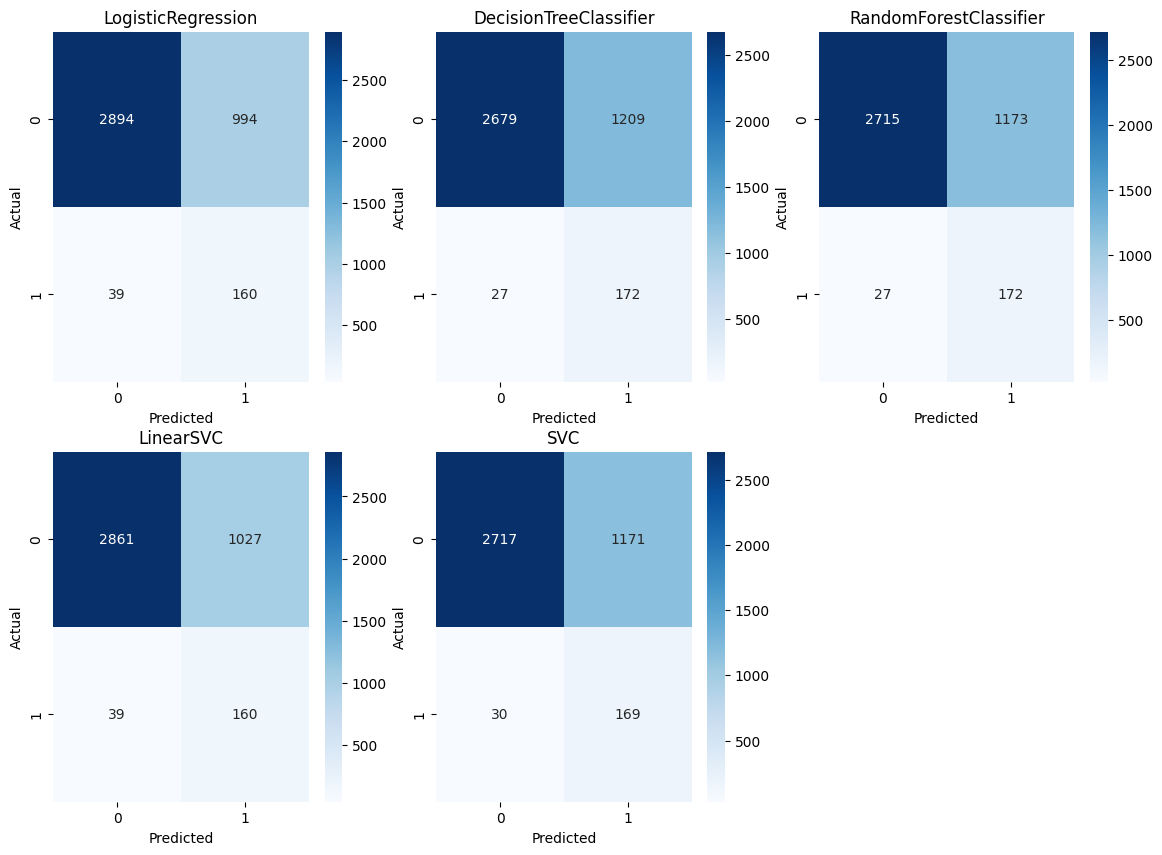

In [29]:
best_models = [clone(best_log_reg), clone(best_tree),
               clone(best_forest), clone(best_linear_svc),
               clone(best_kernel_svc)]
helper_functions.plot_confusion_matrices(best_models, X, y, (14, 10))

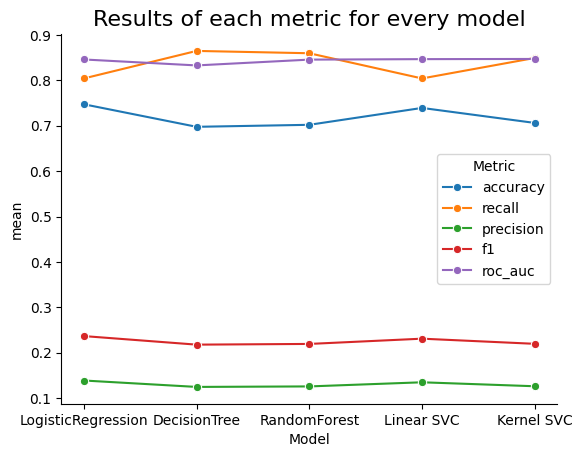

In [30]:
models_results = [best_log_reg_res, best_tree_res, best_forest_res,
                 best_linear_svc_res, best_kernel_svc_res]

# put scores of each model in the same dataframe
model_results_df = pd.concat(models_results, keys=["LogisticRegression",
                                                  "DecisionTree",
                                                  "RandomForest",
                                                  "Linear SVC",
                                                  "Kernel SVC"])

# plot the results
model_results_df = model_results_df.reset_index().rename(
    columns={"level_0": "Model", "level_1": "Metric"})
sns.lineplot(x="Model", y="mean", hue="Metric",
             data=model_results_df, marker='o')
plt.title("Results of each metric for every model", fontsize=16)
sns.despine();

The results of all model are pretty similar and don't differ much. Decision Tree seem to make the least number of False Negatives, while Logistic Regression has the least number of False Positives. Decision Tree is also best at identifying people with stroke. However, as it was stated before, the difference is small.

Regarding ROC AUC, the score is around 83-84 for all models. Support Vector Machine algorithms seem to have higher ROC AUC.

To get the better results, let's try boosting algorithms. We will train AdaBoost algorithm and XGBoost algorithm.

**AdaBoost**

In [31]:
# create Decision Tree stump
estimator=DecisionTreeClassifier(random_state=0, max_depth=1, 
                                 class_weight="balanced")


ada_boost = AdaBoostClassifier(estimator=estimator, n_estimators=200, 
                               random_state=0, algorithm="SAMME")

preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])

pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("ada_boost", ada_boost)])

ada_scores = helper_functions.cross_val_scores(pipe_original, 
                                               X,
                                               y, 
                                               scoring, 
                                               cv)
ada_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.697579,0.864744,0.124615,0.217750,0.776896
std,0.017971,0.079896,0.008731,0.015136,0.036030
min,0.671149,0.750000,0.111524,0.194175,0.721203
25%,0.694002,0.825000,0.122112,0.215743,0.763851
50%,0.695226,0.875000,0.125000,0.217105,0.791549
75%,0.708690,0.925000,0.129825,0.228395,0.792898
max,0.718826,0.948718,0.134615,0.233333,0.814976


We see pretty similar results to above models. Let's tune hyperparameters:

In [32]:
param_grid = {
    'ada_boost__n_estimators': [50, 100, 150],
    'ada_boost__learning_rate': [0.01, 0.1, 1],
    'ada_boost__estimator__max_depth': [1, 2, 3, 5]
}

estimator=DecisionTreeClassifier(random_state=0, 
                                 class_weight="balanced")
ada_boost = AdaBoostClassifier(estimator=estimator, n_estimators=200, 
                               random_state=0, algorithm="SAMME")
preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])

pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("ada_boost", ada_boost)])

best_ada, best_ada_res = helper_functions.find_best_parameters(
    pipe_original, param_grid, X, y, scoring, cv, "roc_auc")
best_ada_res

,mean,std
accuracy,0.726945,0.033093
recall,0.819359,0.103832
precision,0.131684,0.010398
f1,0.226352,0.016713
roc_auc,0.8359,0.027511


Now, we will try **XGBoost** model. To balance classes, we will use scale_pos_weight parameter and set it to number of negative instances / number of positive instances.

In [33]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgboost_model = XGBClassifier(seed=0, scale_pos_weight=scale_pos_weight, 
                              verbosity=0)

preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])

pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("xgboost", xgboost_model)])

xgboost_scores = helper_functions.cross_val_scores(pipe_original, X,
                                                   y, scoring, cv)
xgboost_scores.describe()

,accuracy,recall,precision,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.924148,0.216026,0.213878,0.214575,0.800001
std,0.004183,0.080027,0.063692,0.071673,0.027978
min,0.919217,0.100000,0.117647,0.108108,0.768374
25%,0.920441,0.205128,0.209302,0.210526,0.789865
50%,0.925428,0.225000,0.216216,0.216867,0.793308
75%,0.926561,0.225000,0.230769,0.227848,0.804113
max,0.929095,0.325000,0.295455,0.309524,0.844344


Tune hyperparameters:

In [34]:
param_grid = {
    'xgboost__max_depth': [1, 2, 3, 4],
    'xgboost__learning_rate': [0.01, 0.1],
    'xgboost__reg_lambda': [50, 100, 1000],
    'xgboost__reg_alpha': [0.1, 1, 10, 50],
    'xgboost__colsample_bytree': [0.75, 1], 
}


xgboost_model = XGBClassifier(seed=0, scale_pos_weight=scale_pos_weight, verbosity=0)

preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])

pipe_original = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("xgboost", xgboost_model)])

best_xgboost, best_xgboost_res = helper_functions.find_best_parameters(
    pipe_original, param_grid, X, y, scoring, cv, "roc_auc")
best_xgboost_res

,mean,std
accuracy,0.733297,0.018676
recall,0.803333,0.096408
precision,0.132278,0.016162
f1,0.227058,0.027324
roc_auc,0.851225,0.030443


Now, we'll look at the confusion matrices of the following models:
* XGBoost 
* Decision Tree
* AdaBoost

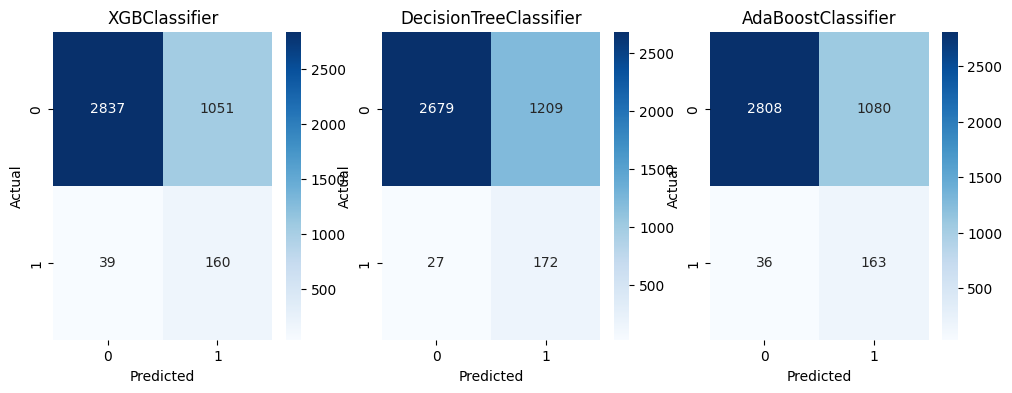

In [35]:
best_models = [clone(best_xgboost), clone(best_tree),
               clone(best_ada)]
helper_functions.plot_confusion_matrices(best_models, X, y, (12, 4))

Suprisingly, Decision Tree model performs similar to boosting model. The reason for this could be the simplicity of our dataset. We can check the depth of the tree:

In [44]:
best_tree.named_steps["tree"].get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

As we see, with such a small depth(2), the decision tree has the highest performance. Let's look at ROC AUC of our models and also check feature importances.

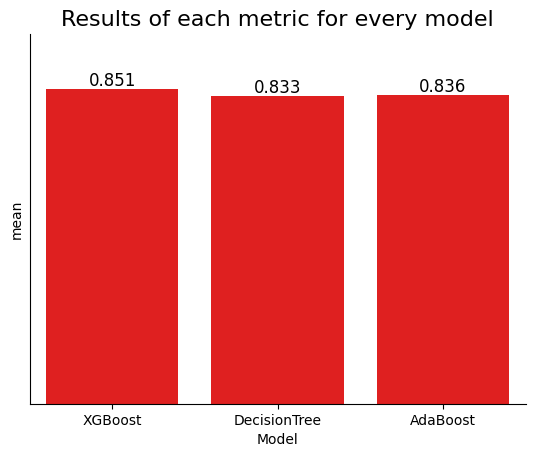

In [45]:
models_results = [best_xgboost_res, 
                  best_tree_res,
                  best_ada_res]

# put scores of each model in the same dataframe
model_results_df = pd.concat(models_results, keys=["XGBoost",
                                                  "DecisionTree",
                                                  "AdaBoost"])

# plot the results
model_results_df = model_results_df.reset_index().rename(
    columns={"level_0": "Model", "level_1": "metric"})
sns.barplot(x="Model", y="mean",
             data=model_results_df[model_results_df["metric"]=="roc_auc"],
           color="red")
plt.title("Results of each metric for every model", fontsize=16)
plt.ylim(0, 1)
helper_functions.customize_bar(axes=plt.gca(), position="v", round_to=3)
sns.despine();

The ROC AUC is a bit higher in XGBoost

In [47]:
# fit the preprocessing to get the order of the features
preprocessing.fit(X)

models = [best_tree.named_steps["tree"], best_xgboost.named_steps["xgboost"],
          best_ada.named_steps["ada_boost"]]

# get feature names of the preprocessor
feature_names = preprocessing.get_feature_names_out().tolist()

# keep only the names
feature_names = [feature[feature.rfind("__")+2:] for feature in feature_names]
for model in models:
    name = str(model)
    name = name[:name.find("(")]
    print(name)

    for feature, importance in zip(feature_names,
                                   model.feature_importances_):
        print(feature, importance)
    print("----------------------------------------")

DecisionTreeClassifier
age 1.0
bmi 0.0
avg_glucose_level 0.0
gender 0.0
ever_married 0.0
Residence_type 0.0
smoking_status 0.0
work_type_Govt_job 0.0
work_type_Never_worked 0.0
work_type_Private 0.0
work_type_Self-employed 0.0
work_type_children 0.0
hypertension 0.0
heart_disease 0.0
----------------------------------------
XGBClassifier
age 0.57679415
bmi 0.08112965
avg_glucose_level 0.07640291
gender 0.05172101
ever_married 0.0
Residence_type 0.0
smoking_status 0.03522621
work_type_Govt_job 0.041065425
work_type_Never_worked 0.0
work_type_Private 0.0
work_type_Self-employed 0.04089966
work_type_children 0.0
hypertension 0.05749138
heart_disease 0.039269548
----------------------------------------
AdaBoostClassifier
age 0.953388021439711
bmi 0.016258296934171537
avg_glucose_level 0.008633195121345185
gender 0.0
ever_married 0.0
Residence_type 0.0
smoking_status 0.01106074121696137
work_type_Govt_job 0.0
work_type_Never_worked 0.0
work_type_Private 0.0
work_type_Self-employed 0.0
work_

## Model Comparison and Final Selection

In our analysis, the Decision Tree model primarily relies on a single feature—age—to make predictions, as indicated by the fact that all other features have zero importance. This suggests that the Decision Tree is overly simplistic, focusing exclusively on age and potentially ignoring other relevant factors.

In contrast, the AdaBoost model, which builds on the Decision Tree, also emphasizes age, giving it a 0.95 importance score. This demonstrates that AdaBoost, while an improvement, still heavily relies on this one feature, potentially limiting its generalization capabilities.

XGBoost, however, offers a more nuanced approach. While age remains highly important (with an importance score of 0.58), XGBoost also identifies and incorporates several other features into its predictions, including BMI, average glucose level, smoking status, work type, heart disease, and hypertension. These features were also found to have associations with the target variable in our Exploratory Data Analysis (EDA), indicating that XGBoost captures a broader range of patterns in the data.

Given XGBoost's higher ROC AUC score and its ability to generalize better by considering multiple relevant features, we have chosen it as our final model. Despite its complexity compared to the Decision Tree, XGBoost's capacity to identify and utilize a diverse set of features makes it more robust and likely to perform well on new data. In future scenarios, we expect that training this model on new data will yield strong performance, while the Decision Tree may struggle due to its narrow focus.

We will also use shap to look at the feaure importances of XGBoost model:

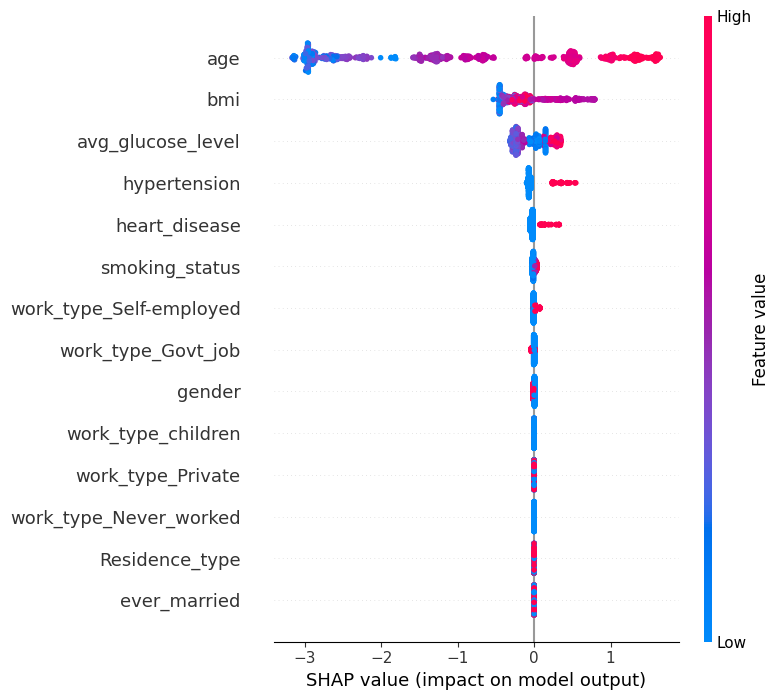

In [48]:
# split the data into two sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, 
                                                  test_size=0.2,
                                                  stratify=y)

# preprocess train set
preprocessing = Pipeline([
        ("preprocess", encode_transform),
        ("knn_impute", KNNImputer(n_neighbors=3))])
preprocessed_X_train = preprocessing.fit_transform(X_train)

model = clone(best_xgboost.named_steps["xgboost"])
model.fit(preprocessed_X_train, y_train)

explainer = shap.TreeExplainer(model)

# add feature names after preprocessing
preprocessed_X_val = preprocessing.transform(X_val)
preprocessed_X_val = pd.DataFrame(preprocessed_X_val, columns=feature_names)

shap_values = explainer.shap_values(preprocessed_X_val)
shap.summary_plot(shap_values, preprocessed_X_val)

Here, the situation is similar as with feature importances scores. The higher age indicates higher chances of stroke. Higher values of bmi and avg_glucose level also increase stroke chances. We see that KNN-imputation for smoking_status is probably useful as higher values of this feature mean higher chances of stroke.

## Results on the test data

In [49]:
X_test = test_set.drop(columns=["id", "stroke"])
y_test = test_set["stroke"]

In [50]:
helper_functions.get_scores(best_xgboost, X_test, y_test, fit=False)

{'accuracy': 0.726027397260274,
 'recall': 0.76,
 'precision': 0.12418300653594772,
 'f1': 0.21348314606741572}

The results on the test data doesn't indicate big overfitting. All of the metrics are almost the same as on the train data. However, the recall is a bit lower.

## Load the model to deploy it

In [ ]:
import pickle
with open("../deployment/stroke_predictor.pkl", "wb") as f:
    pickle.dump(best_xgboost, f)

# Conclusion
After thorough examination, **XGBoost** model has been chosen as the most effective for our problem. The final model's performance on the test set is consistent with results on the training data.

## Key findings:
**Feature importance**: Age has proven to be the most influential factor in predicting stroke. Older people are more susceptible to having this problem. Other factors, such as: BMI, average glucose level, presence of hypertension, heart disease and smoking habits also influence the chances of stroke. However, here their influence is small.  Interestingly, individuals who are **self-employed** or work in **governmental jobs** appear to have a higher risk of stroke. However, further data is needed to confirm the validity of this finding. Gender and type of residence (urban or rural) do not seem to significantly influence the likelihood of a stroke.

**Model Performance**: Here are the results of the test data of our best model:
* accuracy: 0.726027397260274
* recall': 0.76
* precision: 0.12418300653594772
* f1: 0.21348314606741572

Area under the ROC curve is 0.85.
The model’s precision score is notably low, indicating that it frequently fails to accurately identify patients who do have a stroke. However, in this particular scenario, high recall is crucial. Ensuring that the model correctly identifies as many stroke cases as possible is vital because failing to detect a stroke (i.e., predicting no stroke when one is present) can have severe, potentially life-threatening consequences. Thus, while precision is important, prioritizing high recall in this case helps minimize the risk of missing actual stroke cases.

## Recommendations for Addressing the Problem:
* Prioritize Elderly Care: Since older adults are at the greatest risk for stroke, it is essential to ensure they have access to proper healthcare services and medications tailored to their needs.
* Focus on Hypertension and Heart Disease: Individuals with hypertension and heart disease require targeted care and monitoring. Additionally, those who are self-employed or work in government roles may benefit from focused interventions. Promoting healthier lifestyles, encouraging regular physical activity, and supporting mental health within these groups could lead to significant improvements in their overall health and reduce stroke risk.

## Suggestion on improving the analysis:
* Incorporate the creation of the MultipleGroup and CabinCount features into our pipeline. These features were generated after merging the datasets to capture complete information about all passengers on the ship. We could create dictionaries to store the number of people in each cabin and the number of individuals in each group. This approach would allow us to utilize these dictionaries to generate the features, eliminating the need to input them manually when testing the deployed model.
* Experiment with the VotingClassifier. We could also explore the possibility of combining different algorithms into a single model and analyze the results.
* Utilize an AutoML tool. We could apply AutoML to address this problem and evaluate the scores it produces.